# TDA  with Python using the Gudhi Library  

# Confidence regions for persistence diagrams : data points  

In [1]:
import persistence_statistics as ps

import pandas as pd
import numpy as np
import pickle as pickle
import gudhi as gd  
import seaborn as sbs
from scipy.spatial import distance_matrix
from pylab import *

## Introduction

In this tutorial, we introduce confidence regions for persistence diagrams built on a set of data points. We present the subsampling approach of [Fasy etal. 2014 AoS](https://projecteuclid.org/download/pdfview_1/euclid.aos/1413810729). An alternative method is the bottleneck bootstrap method introduced in [Chazal etal. 2018](http://www.jmlr.org/papers/v18/15-484.html) and presented in this [notebook](Tuto-GUDHI-ConfRegions-PersDiag-BottleneckBootstrap.ipynb). See [this notebook](Tuto-GUDHI-persistence-diagrams.ipynb) for an introduction to persistence diagrams with Gudhi.

<img src="Images/persistence.png"  style="width: 600px;"/>

For many applications of persistent homology, we observe topological features close to the diagonal. Since they correspond to topological structures that die very soon after they appear in the filtration, these points are generally considered as "topological noise". Confidence regions for persistence diagram provide a rigorous framework to this idea.

Confidence regions for persistence diagrams provide a rigorous framework for selecting significant topological features in a persistence diagram. We use the bottleneck distance $d_b$ to define confidence regions. We see point clouds as random variables. Under this approach, persistence diagrams are also seen as random quantities.

## Confidence regions for persistence diagrams for point cloud data in $\mathbb R^d$

We introduce the method for a simulated dataset.

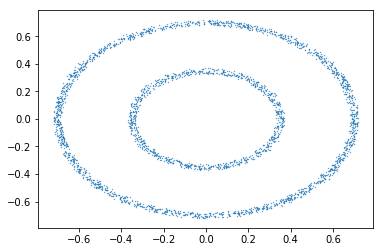

In [2]:
U1 = np.random.uniform(0,2 *  pi,size= 1000)
V1 = np.array([[0.35 * cos(u) +0.02*np.random.uniform(-1,1) ,
                0.35 *sin(u)+0.02*np.random.uniform(-1,1)] for u in U1])
U2 = np.random.uniform(0,2 *  pi,size= 2000)
V2 = np.array([[0.7* cos(u) +0.02*np.random.uniform(-1,1) ,
                0.7*sin(u)+0.02*np.random.uniform(-1,1)] for u in U2])
W = np.concatenate((V1,V2), axis=0)
plt.scatter(W[:,0],W[:,1],s=0.1);


#### Subsampling approach

Let $\mathbb X$ and $\mathbb Y$ be two compact sets.
For the filtrations given below, persistence homology is stable with respect of Hausdorff perturbations:
$$
d_b\left( Dgm \left(Filt(\mathbb X) \right)  ,  Dgm \left(  Filt(\mathbb Y) \right)\right)
\leq C_{Filt}
 Haus \left(\mathbb X, \mathbb Y \right)
$$ 

The previous inequality is valid for the following Gudhi filtrations: 
- for the Rips complex filtration with $C_{Rips} = 2$, 
- for the $\sqrt{alpha}$-complexes filtration (see further) with $C_{Alpha}= 1$. 

Following [Fasy etal. 2014 AoS](https://projecteuclid.org/download/pdfview_1/euclid.aos/1413810729) we derive confidence sets for persistence diagrams (for $d_b$) from confidence sets for compact sets (for $Haus$). Let $\mathbb X_n$ be a sample from a distribution $P$ with compact support $\mathbb X$. 
The aim is to find a parameter $c_\alpha$ such that

$$ P ( Hauss(\mathbb X_n, \mathbb X) \leq c_\alpha)  \geq  1-\alpha .$$

The confidence set  $\mathcal C$ we consider is a subset of all persistence diagrams whose bottleneck distance to $Dgm \left(Filt(\mathbb X_n) \right) $ is less than $d_\alpha$:
$$ \left\{ Dgm   \:  |  \:  d_b \left( Diag  , Dgm \left(Filt(\mathbb X_n) \right)   \right) c\leq d_\alpha  \right\},    $$
with 
$$ d_\alpha = C_{Filt} c_\alpha .$$

The `hausd_interval` function from the `persistence_statistics` module implements the subsampling method of [Fasy etal. 2014 AoS](https://projecteuclid.org/download/pdfview_1/euclid.aos/1413810729), it outputs an estimation $\hat c_\alpha$ of $c_\alpha$. By default a multiprocessing computation is applied.

In [3]:
hatc = ps.hausd_interval(data=W,level = 0.90, m = 2500)
print(hatc)

0.05642562098567528


#### Stability and confidence region for the $\sqrt{alpha}$-filtration

When computing confidence regions for alpha complexes, we need to be careful with the scale of values of the filtration because the filtration value of each simplex is computed as the square of the circumradius of the simplex (if the circumsphere is empty).

In [4]:
Alpha_complex_W = gd.AlphaComplex(points = W)
Alpha_simplex_tree_W = Alpha_complex_W.create_simplex_tree() 

We change the filtration value of each simplex by taking the square root of the filtration values:

In [5]:
Alpha_simplex_tree_W_list = Alpha_simplex_tree_W.get_filtration()

In [6]:
for splx in Alpha_simplex_tree_W_list:
    Alpha_simplex_tree_W.assign_filtration(splx[0],filtration= np.sqrt(splx[1]))

Now we can compute persistence for the rescaled $\sqrt{alpha}$ complex filtration.

In [7]:
pers_alpha_W= Alpha_simplex_tree_W.persistence()

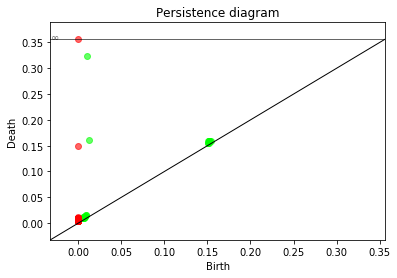

In [8]:
gd.plot_persistence_diagram(pers_alpha_W);

We now define the confidence region for this persistence diagram. We have to take a band of width $ d_\alpha = C_{Filt} c_\alpha $ $\hat c_\alpha$ to compute and plot the confidence band. The `band` parameter is the vertical height of the confidence region, it is thus twice the value of $\hat c _\alpha$ (because the bottleneck distance is based on the $\ell_\infty$ norm).

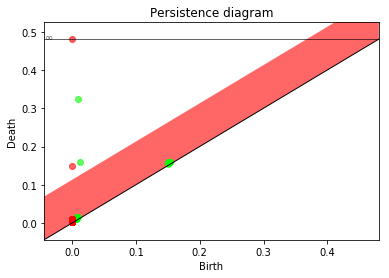

In [9]:
gd.plot_persistence_diagram(pers_alpha_W, band=2 * hatc);

Only the topological features above the red band are considered as significant. Here we select the main topological features by this way.

Generally speaking, the procedure is very conservative: the band is very large and only very few topological features are seen as significant. An alternative approach is the bottleneck bootstrap method, see this [notebook](Tuto-GUDHI-ConfRegions-PersDiag-BottleneckBootstrap.ipynb). 

## Confidence regions for persistence diagrams of filtrations based on pairwise distances

The subsampling approach can be also applied when data come has a matrix of pairwise distances.

We illustrate the procedure with the `trefoil_dist` dataset which contains the distances between 1000 points sampled in the neighborhood of a trefoil curve.

In [10]:
trefoil_dist = pickle.load( open( "./datasets/trefoil_dist", "rb" ) )

We use again the `hausd_interval` function to infer the Hausdorff distance between the data and the support of the underlying distribution of the data.

In [11]:
hatc = ps.hausd_interval(trefoil_dist,pairwise_dist=True,level = 0.90, m = 900)
print(hatc)

0.396104059680682


Now, we define the Rips complex filtration from the matrix of pairwise distances:

In [12]:
skeleton_trefoil = gd.RipsComplex(distance_matrix = trefoil_dist,max_edge_length=2) 
Rips_simplex_tree_trefoil = skeleton_trefoil.create_simplex_tree(max_dimension=2)

and we compute persistence on this filtration:

In [13]:
BarCodes_trefoil = Rips_simplex_tree_trefoil.persistence()

To define a confidence band for the persistence diagram, we have to take a band of width $ \hat d_\alpha = 2 \hat c_\alpha$.

The `band` parameter being the vertical height of the confidence region, it is twice the value of $\hat d _\alpha$ (because the bottleneck distance is based on the $\ell_\infty$ norm).

So finally we take this band parameter equal to four times $\hat c_\alpha$.

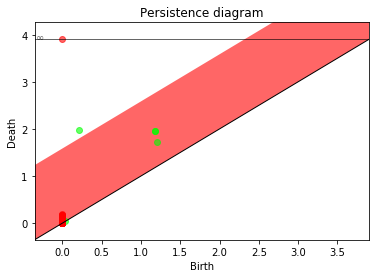

In [14]:
gd.plot_persistence_diagram(BarCodes_trefoil,band = 4*hatc);

We see that only one topological feature of dimension 1 is seen as a significant. An alternative approach is the bottleneck bootstrap method, see this [notebook](Tuto-GUDHI-ConfRegions-PersDiag-BottleneckBootstrap.ipynb). 